# NEURO-105: Statistics and Probability using Python
## Lesson 4 - Wednesday 28/1/26 (Part 1)

**Instructor:** Alexandros Pittis  
**Course:** MSc in Neurosciences, University of Crete

---

### Objectives
1. Understanding p-values through permutation tests
2. Recap exercises combining previous concepts

---

## Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

print("Libraries loaded!")

Libraries loaded!


In [15]:
pd.__path__

['/opt/homebrew/Caskroom/mambaforge/base/envs/python_course/lib/python3.11/site-packages/pandas']

---
## Part 1: What is a P-value?

We'll use our Parkinson's data to understand what a p-value means.

In [46]:
# Load the Parkinson's data
url = "https://raw.githubusercontent.com/cgenomicslab/Courses/refs/heads/main/MScNeuro/2026/data/parkinsons_expression.csv"
data = pd.read_csv(url)

data.head(20)

,sample_id,condition,SNCA,PARK2,PINK1,DJ1,LRRK2,GBA,ATP13A2,MAPT,BDNF,TH,SLC6A3,DRD2,COMT,GAD1,SYP
0,S01,Control,8.2,7.5,6.8,7.1,5.9,8.3,6.2,7.8,6.5,9.1,7.2,6.8,7.4,8.1,7.9
1,S02,Control,7.9,7.8,6.5,7.3,6.1,8.1,6.4,7.5,6.8,8.8,7.5,6.5,7.2,8.3,8.1
2,S03,Control,8.4,7.2,6.9,6.9,5.7,8.5,6.1,7.9,6.3,9.3,7.0,6.9,7.6,7.9,7.7
3,S04,Control,8.0,7.6,6.6,7.2,6.0,8.0,6.3,7.6,6.6,8.9,7.3,6.6,7.3,8.2,8.0
4,S05,Control,8.3,7.4,6.7,7.0,5.8,8.4,6.0,7.7,6.4,9.0,7.1,6.7,7.5,8.0,7.8
5,S06,Control,7.8,7.9,6.4,7.4,6.2,7.9,6.5,7.4,6.9,8.7,7.6,6.4,7.1,8.4,8.2
6,S07,Control,8.1,7.3,6.8,7.1,5.9,8.2,6.2,7.8,6.5,9.2,7.2,6.8,7.4,8.1,7.9
7,S08,Control,8.5,7.1,7.0,6.8,5.6,8.6,5.9,8.0,6.2,9.4,6.9,7.0,7.7,7.8,7.6
8,S09,Control,7.7,8.0,6.3,7.5,6.3,7.8,6.6,7.3,7.0,8.6,7.7,6.3,7.0,8.5,8.3
9,S10,Control,8.2,7.5,6.7,7.0,5.9,8.3,6.2,7.7,6.5,9.0,7.2,6.7,7.4,8.1,7.9


In [17]:
data['condition'] == 'Control'

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
Name: condition, dtype: bool

In [20]:
data[data['condition'] == 'Control']['SNCA'].values

array([8.2, 7.9, 8.4, 8. , 8.3, 7.8, 8.1, 8.5, 7.7, 8.2])

In [21]:
# Get SNCA expression for each group
control = data[data['condition'] == 'Control']['SNCA'].values
pd_group = data[data['condition'] == 'PD']['SNCA'].values

print("Control:", control)
print("PD:", pd_group)

Control: [8.2 7.9 8.4 8.  8.3 7.8 8.1 8.5 7.7 8.2]
PD: [ 9.8 10.1  9.5  9.9 10.3  9.6  9.7 10.   9.4  9.8]


In [30]:
float(control.mean())

8.110000000000001

In [44]:
# The observed difference in means
observed_diff = pd_group.mean() - control.mean()
# observed_diff = 0.5
print(observed_diff)

1.6999999999999975


In [37]:
print("Control mean:", round(control.mean(), 2))
print("PD mean:", round(pd_group.mean(), 2))
print("Observed difference:", round(observed_diff, 1))

Control mean: 8.11
PD mean: 9.81
Observed difference: 1.7


### Question

We see a difference of ~1.7 between groups.

**Could this difference occur just by chance?**

This is what the p-value is, the probability that the observed difference is random.

---
## Part 2: Permutation Test

### Null Hypothesis

**Null hypothesis (H₀):** There is NO real difference between Control and PD groups.

If the null hypothesis is true, then it should not matter which samples are called "Control" and which are called "PD" — we could shuffle the labels and get similar differences.

### Logic

1. Combine all 20 values into one pool
2. Randomly shuffle and split into two groups of 10
3. Calculate the difference in means
4. Repeat many times → build a distribution of "random differences"
5. See where our observed difference falls in this distribution

In [47]:
[control, pd_group]

[array([8.2, 7.9, 8.4, 8. , 8.3, 7.8, 8.1, 8.5, 7.7, 8.2]),
 array([ 9.8, 10.1,  9.5,  9.9, 10.3,  9.6,  9.7, 10. ,  9.4,  9.8])]

In [48]:
np.concatenate([control, pd_group])

array([ 8.2,  7.9,  8.4,  8. ,  8.3,  7.8,  8.1,  8.5,  7.7,  8.2,  9.8,
       10.1,  9.5,  9.9, 10.3,  9.6,  9.7, 10. ,  9.4,  9.8])

In [49]:
# Step 1: Combine all values
all_values = np.concatenate([control, pd_group])

print("All 20 values:", all_values)
print("Total samples:", len(all_values))

All 20 values: [ 8.2  7.9  8.4  8.   8.3  7.8  8.1  8.5  7.7  8.2  9.8 10.1  9.5  9.9
 10.3  9.6  9.7 10.   9.4  9.8]
Total samples: 20


In [61]:
print(all_values)
print(np.random.permutation(all_values))

[ 8.2  7.9  8.4  8.   8.3  7.8  8.1  8.5  7.7  8.2  9.8 10.1  9.5  9.9
 10.3  9.6  9.7 10.   9.4  9.8]
[ 9.9  8.4  9.7  9.6  8.2  7.7  9.8  9.8  7.9  7.8 10.3  8.3 10.   8.2
  8.5  8.1  9.5 10.1  9.4  8. ]


In [68]:
# Step 2-3: One random shuffle
# Check np.random.permutation?
shuffled = np.random.permutation(all_values)

# Split into two groups of 10
random_control = shuffled[:10]
random_pd = shuffled[10:]

# Calculate difference
random_diff = random_pd.mean() - random_control.mean()

print("Random control mean:", round(random_control.mean(), 2))
print("Random PD mean:", round(random_pd.mean(), 2))
print("Random difference:", round(random_diff, 2))

Random control mean: 8.51
Random PD mean: 9.41
Random difference: 0.9


In [95]:
# Step 4: Repeat 10000 times
n_permutations = 10000
random_differences = []

for i in range(n_permutations):
    # Shuffle
    shuffled = np.random.permutation(all_values)
    
    # Split
    random_control = shuffled[:10]
    random_pd = shuffled[10:]
    
    # Calculate difference
    diff = random_pd.mean() - random_control.mean()
    # method append adds to the end of list
    random_differences.append(diff)

In [96]:
random_differences[9999:10002]

[np.float64(-0.7599999999999998)]

In [97]:
random_differences = np.array(random_differences)

print("Generated", len(random_differences), "random differences")
print("Range:", round(random_differences.min(), 2), "to", round(random_differences.max(), 2))

Generated 10000 random differences
Range: -1.44 to 1.46


### Step 5: Visualize the Null Distribution

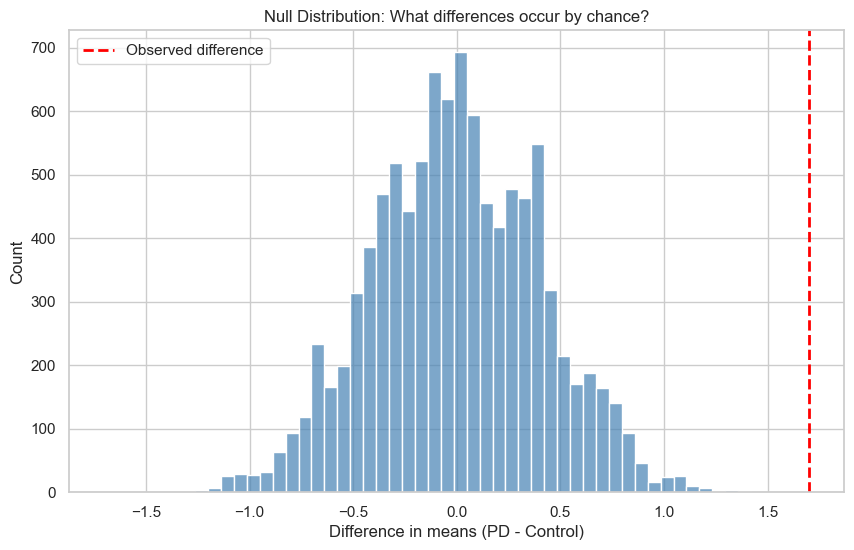

In [85]:
# Plot the distribution of random differences
plt.figure(figsize=(10, 6))

# Histogram of random differences (the null distribution)
sns.histplot(random_differences, bins=50, color='steelblue', alpha=0.7)

# Mark the observed difference
plt.axvline(observed_diff, color='red', linewidth=2, linestyle='--', label='Observed difference')

plt.xlabel('Difference in means (PD - Control)')
plt.ylabel('Count')
plt.title('Null Distribution: What differences occur by chance?')
plt.legend()
plt.show()

**Interpretation:**
- The blue histogram shows differences we would see if there was NO real effect (just random chance)
- The red line is our observed difference
- Our observed difference is far in the tail → unlikely to occur by chance

### Calculating the P-value

The p-value is simply: **What fraction of random differences are as extreme (or more extreme) than our observed difference?**

In [98]:
# One-sided p-value: How many random differences are >= observed?
p_value_one_sided = np.sum(random_differences >= observed_diff) / n_permutations

print("One-sided p-value:", p_value_one_sided)

One-sided p-value: 0.0


In [99]:
# Two-sided p-value: How many random differences are as extreme in EITHER direction?
p_value_two_sided = np.sum(np.abs(random_differences) >= np.abs(observed_diff)) / n_permutations

print("Two-sided p-value:", p_value_two_sided)

Two-sided p-value: 0.0


### Visualizing One-sided vs Two-sided

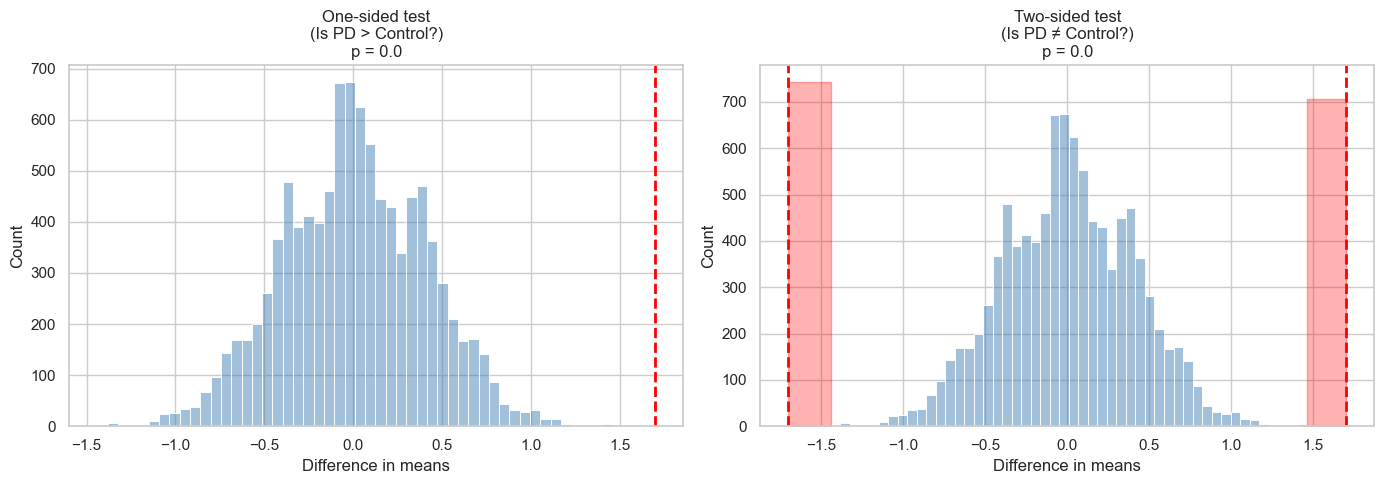

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# One-sided test
ax1 = axes[0]
sns.histplot(random_differences, bins=50, color='steelblue', alpha=0.5, ax=ax1)
ax1.axvline(observed_diff, color='red', linewidth=2, linestyle='--')

# Shade the extreme region (one-sided)
extreme_values = random_differences[random_differences >= observed_diff]
if len(extreme_values) > 0:
    ax1.fill_betweenx([0, ax1.get_ylim()[1]], observed_diff, random_differences.max(), 
                      color='red', alpha=0.3)
ax1.set_xlabel('Difference in means')
ax1.set_ylabel('Count')
ax1.set_title('One-sided test\n(Is PD > Control?)\np = ' + str(round(p_value_one_sided, 4)))

# Two-sided test
ax2 = axes[1]
sns.histplot(random_differences, bins=50, color='steelblue', alpha=0.5, ax=ax2)
ax2.axvline(observed_diff, color='red', linewidth=2, linestyle='--')
ax2.axvline(-observed_diff, color='red', linewidth=2, linestyle='--')

# Shade both tails
ax2.fill_betweenx([0, ax2.get_ylim()[1]], observed_diff, random_differences.max(), 
                  color='red', alpha=0.3)
ax2.fill_betweenx([0, ax2.get_ylim()[1]], random_differences.min(), -observed_diff, 
                  color='red', alpha=0.3)
ax2.set_xlabel('Difference in means')
ax2.set_ylabel('Count')
ax2.set_title('Two-sided test\n(Is PD ≠ Control?)\np = ' + str(round(p_value_two_sided, 4)))

plt.tight_layout()
plt.show()

### One-sided vs Two-sided: When to use which?

| Test | Question | Use when... |
|------|----------|-------------|
| **One-sided** | "Is A greater than B?" | You have a specific directional hypothesis |
| **Two-sided** | "Is A different from B?" | You don't know which direction (default choice) |

**Note:** Two-sided p-value ≈ 2 × one-sided p-value

### Compare with t-test

In [102]:
# t-test gives similar result
t_stat, t_pvalue = stats.ttest_ind(pd_group, control)

print("Permutation p-value (two-sided):", round(p_value_two_sided, 4))
print("t-test p-value (two-sided):", round(t_pvalue, 4))

Permutation p-value (two-sided): 0.0
t-test p-value (two-sided): 0.0


The permutation test and t-test give very similar p-values. The permutation test is conceptually simpler and makes fewer assumptions.

---
## Part 3: Summary - What is a P-value?

**P-value:** The probability of observing a result as extreme as ours (or more extreme) if there was NO real effect.

**Small p-value (< 0.05):**
- The result is unlikely to occur by random chance
- We reject the null hypothesis
- The effect is "statistically significant"

**Large p-value (> 0.05):**
- Our result could occur by random chance
- We cannot reject the null hypothesis
- The effect is "not statistically significant"

**Important:** "Not significant" ≠ "No effect". It just means we can't distinguish from random chance with our data.

---
## Part 4: Exercises

These exercises combine concepts from all previous lessons.

### Exercise 1: Load and Explore

Load the penguins dataset. How many penguins of each species are there?

In [ ]:
# YOUR CODE HERE


### Exercise 2: Filter and Calculate

Using the penguins dataset:
1. Filter to keep only Adelie penguins
2. Calculate the mean and standard deviation of their body mass

In [ ]:
# YOUR CODE HERE


### Exercise 3: Correlation

Using the penguins dataset (all species):
1. Calculate the Pearson correlation between flipper_length_mm and body_mass_g
2. Is this correlation statistically significant?

In [ ]:
# YOUR CODE HERE


### Exercise 4: Group Comparison

Using the penguins dataset:
1. Compare body_mass_g between male and female penguins using a t-test
2. Create a boxplot to visualize the difference
3. Is the difference statistically significant?

In [ ]:
# YOUR CODE HERE


### Exercise 5: Complete Analysis

Using the Parkinson's data, analyze the TH gene (Tyrosine Hydroxylase):
1. Calculate mean expression for Control and PD groups
2. Create a visualization (boxplot or histogram)
3. Perform both t-test and Mann-Whitney U test
4. What do you conclude about TH expression in Parkinson's disease?

In [ ]:
# YOUR CODE HERE


---

## Next: Project Introduction

---
*NEURO-105 - MSc in Neurosciences, University of Crete*